In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [236]:
# Importing the packages
import numpy as np
import pandas as pd
#import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import scale, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
#from sklearn.model_selection import KFold
from sklearn.ensemble import VotingClassifier
import warnings
warnings.simplefilter(action = "ignore")
sns.set()
plt.style.use('ggplot')
%matplotlib inline

In [237]:
df_d=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/diabetescleaned.csv')
df_h=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/heartcleaned.csv')
df_k=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/kidneycleaned.csv')
df_l=pd.read_csv('/content/drive/MyDrive/Disease Prediction 2/Cleaned Datasets/livercleaned.csv')

In [238]:
import pandas as pd

def drop_weak_correlations_with_target(data, target_column, threshold):
    """Drops features with correlations below `threshold` (absolute value) with respect to the target column.  Assumes target is the last column .
    Args:
        data: A pandas DataFrame.
        target_column: The name of the classification target feature.
        threshold: The correlation coefficient threshold.

    Returns:
        A new DataFrame with weakly correlated features removed.
    """
    correlations = data.corr()[target_column].abs()[:-1]  # Exclude the target itself
    weak_features = correlations[correlations < threshold].index
    return data.drop(weak_features, axis=1)

def get_feature_count(data, target_column, threshold):
    new_data = drop_weak_correlations_with_target(data.copy(), target_column, threshold)
    return len(new_data.columns) - 1  # Subtract 1 for the target column

def find_threshold(datasets, target_column, desired_feature_count):
    threshold = 0.0
    increment = 0.1

    while True:
        feature_counts = [get_feature_count(data, target_column, threshold) for data in datasets]
        min_features = min(feature_counts)
        max_features = max(feature_counts)

        if min_features == max_features == desired_feature_count:
            return threshold

        if max_features > desired_feature_count:
            threshold += increment
        else:
            threshold -= increment
            increment /= 2




In [239]:
# ... (Load your datasets df_d, df_h, df_k, and df_l)
datasets=[df_k]
target_column = "class"  # Example; adjust accordingly
desired_feature_count = 8

final_threshold = find_threshold(datasets.copy(), target_column, desired_feature_count)
print("Final Threshold:", final_threshold)

Final Threshold: 0.39375000000000004


In [240]:
# Your dataset and target column (assuming 'Outcome' is the correct target for the kidney disease dataset)
data = df_k.copy()  # Make a copy to avoid modifying your original dataset
target_column = "class"

# The threshold determined using the iterative process
final_threshold = 0.39375000000000004

# Calling the function to drop weakly correlated features
new_data_k = drop_weak_correlations_with_target(data, target_column, final_threshold)

print(new_data_k.head())  # Display the first few rows of the modified dataset

   specific_gravity  albumin  pus_cell  haemoglobin  packed_cell_volume  \
0             1.020      1.0         1         15.4                44.0   
1             1.020      4.0         1         11.3                38.0   
2             1.010      2.0         1          9.6                31.0   
3             1.005      4.0         0         11.2                32.0   
4             1.010      2.0         1         11.6                35.0   

   red_blood_cell_count  hypertension  diabetes_mellitus  class  
0                   5.2             1                  1      0  
1                   2.1             0                  0      0  
2                   5.7             0                  1      0  
3                   3.9             1                  0      0  
4                   4.6             0                  0      0  


In [241]:
# ... (Load your datasets df_d, df_h, df_k, and df_l)
datasets=[df_h]
target_column = "target"  # Example; adjust accordingly
desired_feature_count = 8

final_threshold = find_threshold(datasets.copy(), target_column, desired_feature_count)
print("Final Threshold:", final_threshold)

Final Threshold: 0.25000000000000006


In [242]:
# Your dataset and target column (assuming 'Outcome' is the correct target for the kidney disease dataset)
data = df_h.copy()  # Make a copy to avoid modifying your original dataset
target_column = "target"

# The threshold determined using the iterative process
final_threshold = 0.25000000000000006

# Calling the function to drop weakly correlated features
new_data_h = drop_weak_correlations_with_target(data, target_column, final_threshold)

print(new_data_h.head())  # Display the first few rows of the modified dataset

   sex  cp   thalach  exang  oldpeak  slope  ca  thal  target
0    1   3  5.010635      0      2.3      0   0     1       1
1    1   2  5.231109      0      3.5      0   0     2       1
2    0   1  5.147494      0      1.4      2   0     2       1
3    1   1  5.181784      0      0.8      2   0     2       1
4    0   0  5.093750      1      0.6      2   0     2       1


In [243]:
# ... (Load your datasets df_d, df_h, df_k, and df_l)
datasets=[df_d]
target_column = "Outcome"  # Example; adjust accordingly
desired_feature_count = 8

final_threshold = find_threshold(datasets.copy(), target_column, desired_feature_count)
print("Final Threshold:", final_threshold)

Final Threshold: 0.23750000000000007


In [244]:
# Your dataset and target column (assuming 'Outcome' is the correct target for the kidney disease dataset)
data = df_d.copy()  # Make a copy to avoid modifying your original dataset
target_column = "Outcome"

# The threshold determined using the iterative process
final_threshold = 0.23750000000000007

# Calling the function to drop weakly correlated features
new_data_d = drop_weak_correlations_with_target(data, target_column, final_threshold)

print(new_data_d.head())  # Display the first few rows of the modified dataset

   Glucose  SkinThickness  Insulin   BMI  Age  Outcome  \
0    148.0           35.0    169.5  33.6   50        1   
1     85.0           29.0    102.5  26.6   31        0   
2    183.0           32.0    169.5  23.3   32        1   
3     89.0           23.0     94.0  28.1   21        0   
4    137.0           35.0    168.0  43.1   33        1   

   NewInsulinScore_Normal  NewGlucose_Normal  NewGlucose_Secret  
0                       0                  0                  1  
1                       1                  1                  0  
2                       0                  0                  1  
3                       1                  1                  0  
4                       0                  0                  1  


In [245]:
# ... (Load your datasets df_d, df_h, df_k, and df_l)
datasets=[df_l]
target_column = "Result"  # Example; adjust accordingly
desired_feature_count = 8

final_threshold = find_threshold(datasets.copy(), target_column, desired_feature_count)
print("Final Threshold:", final_threshold)

Final Threshold: 0.1


In [246]:
# Your dataset and target column (assuming 'Outcome' is the correct target for the kidney disease dataset)
data = df_l.copy()  # Make a copy to avoid modifying your original dataset
target_column = "Result"

# The threshold determined using the iterative process
final_threshold = 0.1

# Calling the function to drop weakly correlated features
new_data_l = drop_weak_correlations_with_target(data, target_column, final_threshold)

print(new_data_l.head())  # Display the first few rows of the modified dataset

   Gender  Total Bilirubin  Direct Bilirubin  Alkaline_Phosphotase  \
0  Female              0.7               0.1                 187.0   
1    Male             10.9               5.5                 699.0   
2    Male              7.3               4.1                 490.0   
3    Male              1.0               0.4                 182.0   
4    Male              3.9               2.0                 195.0   

   Alamine_Aminotransferase  Aspartate_Aminotransferase  Albumin  \
0                      16.0                        18.0      3.3   
1                      64.0                       100.0      3.2   
2                      60.0                        68.0      3.3   
3                      14.0                        20.0      3.4   
4                      27.0                        59.0      2.4   

   Albumin_and_Globulin Ratio  Result  
0                        0.90       1  
1                        0.74       1  
2                        0.89       1  
3         

In [247]:
## if score==negative, mark 0 ;else 1
def partition(x):
    if x =='Male':
        return 0
    return 1

new_data_l['Gender'] = new_data_l['Gender'].map(partition)

In [248]:
# More efficient target conversion
def convert_targets(labels):
    return [0 if label == 1 else 1 for label in labels]


In [249]:
def fix_liver_labels(df):
    if df['Result'].dtype == 'object':
        df['Result'] = df['Result'].astype(int)

    # Mapping 1 to 0 and 2 to 1
    df.loc[df['Result'] == 1, 'Result'] = 0
    df.loc[df['Result'] == 2, 'Result'] = 1

    return df


In [250]:
new_data_l = fix_liver_labels(new_data_l.copy())

In [251]:
# Split the data into training and testing sets
X_diabetes, X_test_diabetes, y_diabetes, y_test_diabetes = train_test_split(new_data_d.drop('Outcome', axis=1), new_data_d['Outcome'], test_size=0.3, random_state=42)
X_heart, X_test_heart, y_heart, y_test_heart = train_test_split(new_data_h.drop('target', axis=1), new_data_h['target'], test_size=0.3, random_state=42)
X_kidney, X_test_kidney, y_kidney, y_test_kidney = train_test_split(new_data_k.drop('class', axis=1), new_data_k['class'], test_size=0.3, random_state=42)
X_liver, X_test_liver, y_liver, y_test_liver = train_test_split(new_data_l.drop('Result', axis=1), new_data_l['Result'], test_size=0.2, random_state=42)

In [252]:
# Create the individual models
diabetes_model = RandomForestClassifier()
heart_model = RandomForestClassifier()
kidney_model = RandomForestClassifier()
liver_model = RandomForestClassifier()

In [253]:
# Train the individual models
diabetes_model.fit(X_diabetes, y_diabetes)
heart_model.fit(X_heart, y_heart)
kidney_model.fit(X_kidney, y_kidney)
liver_model.fit(X_liver, y_liver)

RandomForestClassifier()

In [254]:
# Create the ensemble model
ensemble_model = VotingClassifier(estimators=[('diabetes', diabetes_model), ('heart', heart_model), ('kidney', kidney_model), ('liver', liver_model)], voting='hard')

In [255]:
# Train the ensemble model
ensemble_model.fit(np.concatenate((X_diabetes, X_heart, X_kidney, X_liver), axis=0), np.concatenate((y_diabetes, y_heart, y_kidney, y_liver), axis=0))

VotingClassifier(estimators=[('diabetes', RandomForestClassifier()),
                             ('heart', RandomForestClassifier()),
                             ('kidney', RandomForestClassifier()),
                             ('liver', RandomForestClassifier())])

In [256]:
# More efficient target conversion
def convert_targets(labels):
    return [0 if label == 1 else 1 for label in labels]


In [257]:
# Evaluate the ensemble model
accuracy = accuracy_score(np.concatenate((y_test_diabetes, y_test_heart, y_test_kidney, y_test_liver), axis=0), ensemble_model.predict(np.concatenate((X_test_diabetes, X_test_heart, X_test_kidney, X_test_liver), axis=0)))
print('Accuracy:', accuracy)

Accuracy: 0.9921421250427058


In [258]:
# Make predictions on the test sets (assumes you've split each dataset into X_test_* and y_test_*)
y_pred_diabetes = diabetes_model.predict(X_test_diabetes)
y_pred_heart = heart_model.predict(X_test_heart)
y_pred_kidney = kidney_model.predict(X_test_kidney)
y_pred_liver = liver_model.predict(X_test_liver)

In [259]:
# Make predictions using the ensemble model:
y_pred_ensemble = ensemble_model.predict(np.concatenate((X_test_diabetes, X_test_heart, X_test_kidney, X_test_liver), axis=0))

In [260]:
def calculate_metrics(X_test, y_test, y_pred, disease_name):
    """Calculates metrics for a specific disease dataset."""

    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='macro')
    precision = precision_score(y_test, y_pred, average='macro')
    recall = recall_score(y_test, y_pred, average='macro')
    cm = confusion_matrix(y_test, y_pred)

    print(f"\nMetrics for {disease_name} dataset:")
    print("Accuracy:", accuracy)
    print("F1-Score:", f1)
    print("Precision:", precision)
    print("Recall:", recall)
    print("Confusion Matrix:\n", cm)

# ... Your code for loading datasets, splitting into train/test sets, and training models

# Individual disease evaluation:
calculate_metrics(X_test_diabetes, y_test_diabetes, y_pred_diabetes, 'diabetes')
calculate_metrics(X_test_heart, y_test_heart, y_pred_heart, 'heart')
calculate_metrics(X_test_kidney, y_test_kidney, y_pred_kidney, 'kidney')
calculate_metrics(X_test_liver, y_test_liver, y_pred_liver, 'liver')




Metrics for diabetes dataset:
Accuracy: 0.8728070175438597
F1-Score: 0.8533762057877814
Precision: 0.8574952902126133
Recall: 0.8496840996840997
Confusion Matrix:
 [[141  13]
 [ 16  58]]

Metrics for heart dataset:
Accuracy: 0.8131868131868132
F1-Score: 0.8117317755871973
Precision: 0.8112244897959184
Recall: 0.812439024390244
Confusion Matrix:
 [[33  8]
 [ 9 41]]

Metrics for kidney dataset:
Accuracy: 0.9833333333333333
F1-Score: 0.9818785865297492
Precision: 0.9871794871794872
Recall: 0.9772727272727273
Confusion Matrix:
 [[76  0]
 [ 2 42]]

Metrics for liver dataset:
Accuracy: 1.0
F1-Score: 1.0
Precision: 1.0
Recall: 1.0
Confusion Matrix:
 [[3880    0]
 [   0 1535]]


In [261]:
def plot_confusion_matrix(y_true, y_pred, disease_name):
    """Plots the confusion matrix for a specific disease."""

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 4))  # Adjust figure size as needed
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='g',
            xticklabels=['Class 0', 'Class 1'],
            yticklabels=['Class 0', 'Class 1'])
    plt.title(f'Confusion Matrix - {disease_name}')
    tick_marks = np.arange(2)  # Assuming binary classification (0 and 1)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

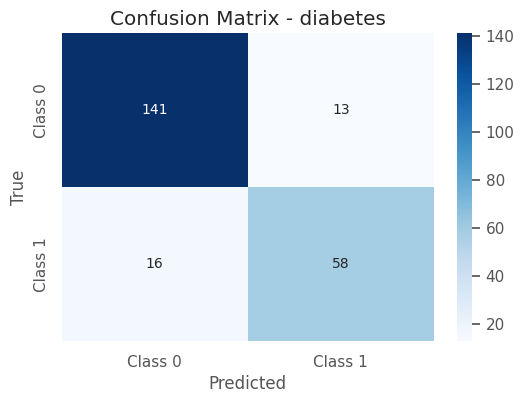

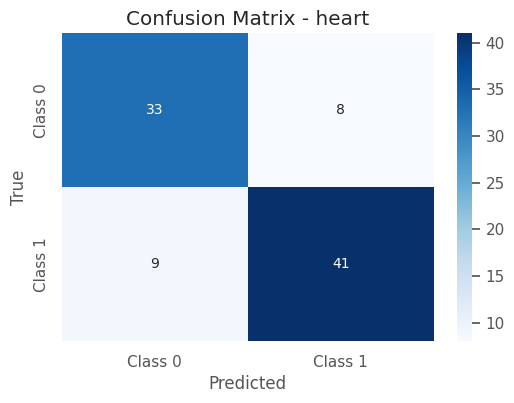

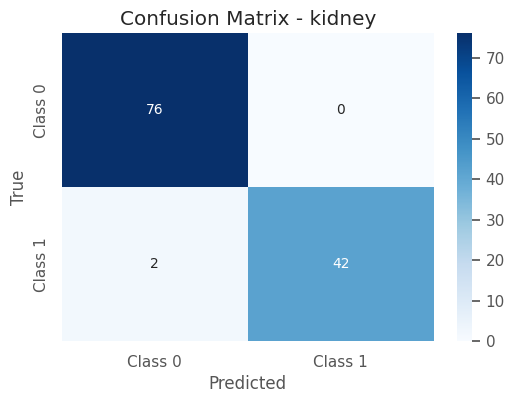

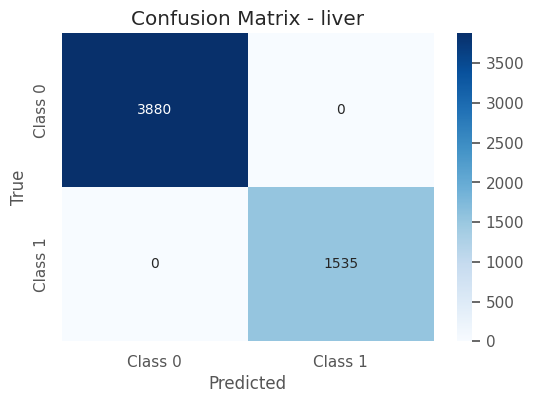

In [262]:
# Plot confusion matrices for each disease:
plot_confusion_matrix(y_test_diabetes, y_pred_diabetes, 'diabetes')
plot_confusion_matrix(y_test_heart, y_pred_heart, 'heart')
plot_confusion_matrix(y_test_kidney, y_pred_kidney, 'kidney')
plot_confusion_matrix(y_test_liver, y_pred_liver, 'liver')

In [ ]:
diseases = ['diabetes', 'heart', 'kidney', 'liver']

for disease in diseases:
    y_test = y_test_sets[disease]
    y_pred = predict(X_test_sets[disease], models[disease]) # Assuming you have predict function
    y_true = convert_targets(y_test)

    # Calculate metrics here and print with the disease name for clarity


In [221]:

# Generate predictions on the combined test sets
y_pred = ensemble_model.predict(np.concatenate((X_test_diabetes, X_test_heart, X_test_kidney, X_test_liver), axis=0))

# Convert targets into consistent 0/1 representation
y_true = convert_targets(np.concatenate((y_test_diabetes, y_test_heart, y_test_kidney, y_test_liver), axis=0))

# Calculate the confusion matrix
cm = confusion_matrix(y_true, y_pred)
print(cm)

[[  17 1629]
 [4050   12]]


In [222]:
import pickle

# Save the trained ensemble model to a file
with open('/content/ensemble_model.pkl', 'wb') as f:
    pickle.dump(ensemble_model, f)


In [148]:
# Load the saved model from file
import pickle
with open('ensemble_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

In [273]:
def predict_disease(disease_type, **kwargs):
    with open('ensemble_model.pkl', 'rb') as f:
        ensemble_model = pickle.load(f)

    if disease_type == 'heart':
        features = np.array([[kwargs.get('sex'), kwargs.get('cp'), kwargs.get('thalach'),
                              kwargs.get('exang'), kwargs.get('oldpeak'), kwargs.get('slope'), kwargs.get('ca'), kwargs.get('thal')]])
    elif disease_type == 'diabetes':
        features = np.array([[kwargs.get('Glucose'), kwargs.get('SkinThickness'), kwargs.get('Insulin'), kwargs.get('BMI'),
                              kwargs.get('Age'), kwargs.get('NewInsulinScore_Normal'), kwargs.get('NewGlucose_Normal'),
                              kwargs.get('NewGlucose_Secret')]])
    elif disease_type == 'liver':
        features = np.array([[kwargs.get('Gender'), kwargs.get('Total_Bilirubin'),
                              kwargs.get('Direct_Bilirubin'), kwargs.get('Alkaline_Phosphotase'),
                              kwargs.get('Alamine_Aminotransferase'), kwargs.get('Aspartate_Aminotransferase'), kwargs.get('Albumin'),
                              kwargs.get('Albumin_and_Globulin_Ratio')]])
    elif disease_type == 'kidney':
        features = np.array([[kwargs.get('specific_gravity'), kwargs.get('albumin'), kwargs.get('pus_cell'),
                              kwargs.get('haemoglobin'), kwargs.get('packed_cell_volume'), kwargs.get('red_blood_cell_count'),
                              kwargs.get('hypertension'), kwargs.get('diabetes_mellitus'),]])
    else:
        return "Invalid disease type"

    prediction = ensemble_model.predict(features)
    return prediction[0]

# Call the function to predict heart disease
prediction = predict_disease(disease_type='heart', sex=1, cp=0, thalach=4.948759890378168, exang=0, oldpeak=3.4, slope=1, ca=2, thal=3)
print("Predicted heart disease status:", prediction)
# Call the function to predict diabetes
prediction = predict_disease(disease_type='diabetes', Glucose=148, SkinThickness=0, Insulin=169, BMI=33.6, Age=50, NewInsulinScore_Normal=0, NewGlucose_Normal=0, NewGlucose_Secret=1)
print("Predicted Diabetes disease status:", prediction)
# Call the function to predict liver disease
prediction = predict_disease(disease_type='liver', Gender=1, Total_Bilirubin=0.7, Direct_Bilirubin=0.1, Alkaline_Phosphotase=187, Alamine_Aminotransferase=16, Aspartate_Aminotransferase=18, Albumin=0, Albumin_and_Globulin_Ratio=0.90)
print("Predicted Liver disease status:", prediction)
# Call the function to predict kidney disease
prediction = predict_disease(disease_type='kidney', specific_gravity=1.025, albumin=0.0, pus_cell=1, haemoglobin=15, packed_cell_volume=52, red_blood_cell_count=5.3, hypertension=0, diabetes_mellitus=0)
print("Predicted Kidney disease status:", prediction)


Predicted heart disease status: 0
Predicted Diabetes disease status: 0
Predicted Liver disease status: 0
Predicted Kidney disease status: 1
